In [2]:
# pip install pydot
# sudo apt-get install graphviz
import sys
sys.path.insert(0, 'compiled_protobufs')
from taskmap_pb2 import TaskMap
import os


In [53]:
from IPython.display import Image, display
import pydot
import requests
from PIL import Image as Im

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
    
def download_image(url, id=0):
    # full_path = os.path.join(os.getcwd(), f'picture{id}.jpg')
    img_data = requests.get(url).content
    # print(requests.get(url).status_code)
    filename = f'img_data{id}.jpg'
    with open(filename, 'wb') as handler:
        handler.write(img_data)
    scale_img_by_width(filename)

def scale_img_by_width(filename):
    basewidth = 200
    img = Im.open(filename)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Im.ANTIALIAS)
    img.save(filename)

In [54]:
from models_indexes.bm25_model import BM25Model

def get_taskgraph():
    model = BM25Model(domain="COOKING")
    taskgraph = model.search_best("pasta")
    return taskgraph

def parse_taskgraph(taskmap:TaskMap):
    print(taskmap)
    title = taskmap.title
    steps = [step.response.screen.paragraphs[0] for step in taskmap.steps]
    steps_urls = [step.response.transcript.image_url for step in taskmap.steps]
    steps_urls[-1] = "https://tastykitchen.com/recipes/wp-content/uploads/sites/2/2011/06/Dianes-pasta-410x271.jpg"
    print(steps_urls)
    requirements = [requirements.name for requirements in taskmap.requirement_list]
    dataset = taskmap.dataset
    
    breakpoint = 15
    multiline_steps = []
    for step in steps:
        words = step.split(" ")
        multiline_steps.append("\n".join([' '.join(words[i:i+breakpoint]) for i in range(0,len(words),breakpoint)]))
        
    parsed_requirements = []
    if len(requirements) > 0:
        parsed_requirements.append("Requirements:")
    for idx, requirement in enumerate(requirements):
        parsed_requirements.append(f"{idx+1}. {requirement}")
    requirements = "\l".join(parsed_requirements)
    
    steps = []
    return {
        "title" : title,
        "steps" : multiline_steps,
        "steps_urls": steps_urls,
        "requirements" : requirements,
        "dataset" : dataset,
    }
    

In [57]:
import os, glob

# url_img = "https://tastykitchen.com/recipes/wp-content/uploads/sites/2/2011/06/Dianes-pasta-410x271.jpg"
url_img = "./pasta_pic.jpg"

def get_visualization(parsed_taskgraph):
    
    # download images
    for idx, img_url in enumerate(parsed_taskgraph["steps_urls"]):
        if img_url != "":
            download_image(img_url, idx)
    
    graph = pydot.Dot(parsed_taskgraph["title"], graph_type='digraph', format="jpg")
    steps = parsed_taskgraph["steps"]
    
    # create title
    title = parsed_taskgraph["title"]
    dataset = parsed_taskgraph["dataset"]
    title_node = pydot.Node(-1, label=f"{title} by {dataset}")
    title_node.set_fontsize(16)
    title_node.set_shape("plaintext")
    graph.add_node(title_node)
    
    # imgNode = pydot.Node(-3 , label="",)
    # imgNode.set_image(os.path.join(os.getcwd(), url_img))
    # imgNode.set_shape("plaintext")
    # graph.add_node(imgNode)
    
    # graph.node(-3 , color='red', image=url_img)
    
    requirements_text = parsed_taskgraph["requirements"]
    requirement_node = pydot.Node(-2, label=f"{requirements_text}\l")
    requirement_node.set_fontsize(10)
    requirement_node.set_shape("note")
    graph.add_node(requirement_node)
    
    nodes = []
    steps = ["START"] + steps
    steps.append("FINISH")

    # Add Nodes for steps
    for idx, step in enumerate(steps):
        node = pydot.Node(idx, label=step)
        node.set_shape("box")
        node.set_fontsize(10)
        nodes.append(node)
        graph.add_node(node)
        print(idx)
        if  idx < len(steps) - 2 and parsed_taskgraph["steps_urls"][idx] != "":
            imgNode = pydot.Node(f"i{idx}", label="",)
            imgNode.set_image(os.path.join(os.getcwd(), f'img_data{idx}.jpg'))
            imgNode.set_shape("plaintext")
            graph.add_node(imgNode)
            edge = pydot.Edge(idx, f'i{idx}', color="white")
            edge.set_len(1)
            graph.add_edge(edge)
            

    nodes[0].set_shape("oval")
    nodes[-1].set_shape("oval")
    
    invisible_edge = pydot.Edge(-1, 0,  color="white")
    graph.add_edge(invisible_edge)

    # Add Edges for steps
    for idx in range(0, len(nodes) - 1):
        edge = pydot.Edge(idx, idx+1)
        edge.set_len(1)
        graph.add_edge(edge)
    
    edge = pydot.Edge(-1, -2, color="white")
    graph.add_edge(edge)
    
    edge = pydot.Edge(-2, 0, color="white")
    graph.add_edge(edge)
    
    graph.write_raw('output_raw.dot')
    graph.write_png('output.png')
    view_pydot(graph)

def delete_downloaded_images():
    # Getting All Files List
    fileList = glob.glob('img_data*.jpg', recursive=False)
        
    # Remove all files one by one
    for file in fileList:
        try:
            os.remove(file)
        except OSError:
            print("Error while deleting file")
    
    
def get_taksgraph_visualization(taskmap:TaskMap):
    parsed_taskgraph = parse_taskgraph(taskmap)
    get_visualization(parsed_taskgraph)
    delete_downloaded_images()
    
    


taskmap_id: "cooking+recipe1m+e913e7d20377b736080a0e7df5f7a37a"
title: "Girls Night Pasta"
source_url: "http://tastykitchen.com/recipes/main-courses/girlse28099-night-pasta/"
requirement_list {
  unique_id: "9f67596a-bd54-443f-b53f-9489b745c53f"
  type: HARDWARE
  name: "16 ounces, weight Rotini Pasta, Cooked"
}
requirement_list {
  unique_id: "7024dfa4-b021-431f-af02-ec96f3ff0ef1"
  type: HARDWARE
  name: "1 whole Roasted Chicken, Picked"
}
requirement_list {
  unique_id: "8e65c4d3-5347-4147-8bcc-4ba574160074"
  type: HARDWARE
  name: "1 cup Sun-Dried Tomatoes, Diced"
}
requirement_list {
  unique_id: "be3acc66-387e-44eb-84f5-cc42d95e5a99"
  type: HARDWARE
  name: "1/2 cups Grated Parmesan Cheese"
}
requirement_list {
  unique_id: "c89bbdba-2d54-4346-9438-14ee66d02481"
  type: HARDWARE
  name: "2 ounces, weight Pine Nuts, Toasted"
}
requirement_list {
  unique_id: "554e691c-36ba-49dd-96c6-63f609435697"
  type: HARDWARE
  name: "1 cup Pesto Sauce (or To Taste)"
}
requirement_list {
  u

/tmp/ipykernel_13380/2877922295.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((basewidth, hsize), Im.ANTIALIAS)


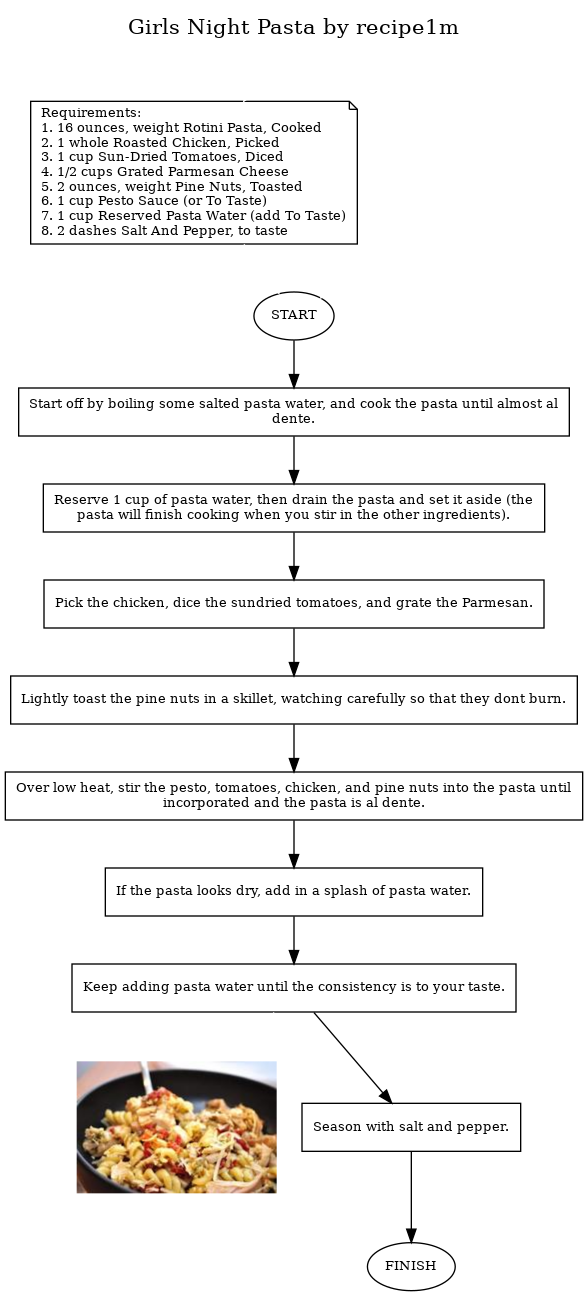

In [58]:
task = get_taskgraph()
get_taksgraph_visualization(task)


In [46]:
help(pydot.Node(-1, label="hallo"))

Help on Node in module pydot object:

class Node(Common)
 |  Node(name='', obj_dict=None, **attrs)
 |  
 |  A graph node.
 |  
 |  This class represents a graph's node with all its attributes.
 |  
 |  node(name, attribute=value, ...)
 |  
 |  name: node's name
 |  
 |  All the attributes defined in the Graphviz dot language should
 |  be supported.
 |  
 |  Method resolution order:
 |      Node
 |      Common
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name='', obj_dict=None, **attrs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  add_style(self, style)
 |  
 |  get_name(self)
 |      Get the node's name.
 |  
 |  get_port(self)
 |      Get the node's port.
 |  
 |  set_name(self, node_name)
 |      Set the node's name.
 |  
 |  to_string(self)
 |      Return string representation of node in DOT language.
 |  
 |  --------------------------------------------------------

In [37]:


(graph,) = pydot.graph_from_dot_file('output_raw.dot')
graph.write_png('output.png')

-1 -> 0  [color=white];
^
Expected "}", found '-'  (at char 1647), (line:17, col:1)


TypeError: cannot unpack non-iterable NoneType object